In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount =True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
cp -rf /content/drive/My\ Drive/kaggle/ /content/

In [ ]:
zipfile.ZipFile('/content/kaggle/histopathologic-cancer-detection.zip').extractall('/content')

In [ ]:
import numpy as np
import torch.nn as nn
import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
import torchvision 
import torchvision.transforms as transforms
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset, random_split
import os
import zipfile
from PIL import Image
import copy
%matplotlib inline

In [ ]:
data_dir = '/content/train_labels.csv'
df = pd.read_csv(data_dir)
df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


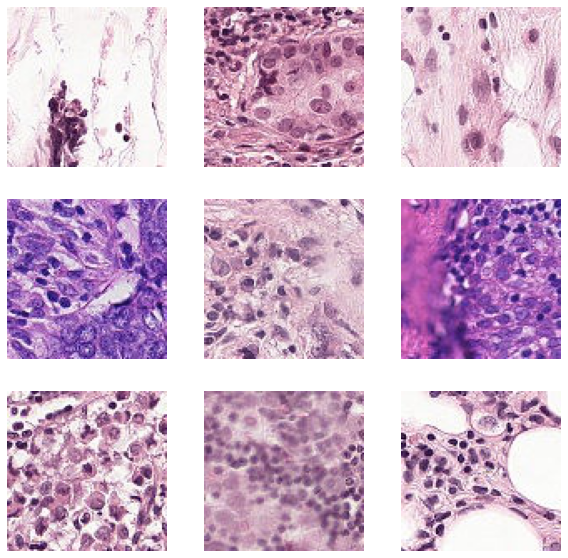

In [ ]:
malig_ids = df[df['label'] == 1]['id'].values

nfig = 3

plt.rcParams['figure.figsize'] = (10,10)

for i,fig_id in enumerate(malig_ids[:nfig**2]):
  
  path = f'/content/train/{fig_id}.tif'
  img = Image.open(path)

  plt.subplot(nfig,nfig,i+1)
  plt.imshow(np.array(img))
  plt.axis("off")



In [ ]:
torch.manual_seed(10)

In [ ]:
df.tail()

,id,label
220020,53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6,0
220021,d4b854fe38b07fe2831ad73892b3cec877689576,1
220022,3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75,0
220023,f129691c13433f66e1e0671ff1fe80944816f5a2,0
220024,a81f84895ddcd522302ddf34be02eb1b3e5af1cb,1


In [ ]:
class CancerDataset(Dataset):

  def __init__(self,data_path,transform,data_type='train'):
    
    path = os.path.join(data_path,data_type)
    list_filenames = os.listdir(path)
    self.filenames = [os.path.join(path,fle) for fle in list_filenames]
    csv = data_type + "_labels.csv"
    label_path = os.path.join(data_path,csv)
    df = pd.read_csv(label_path)
    df.set_index("id", inplace=True)
    self.labels = [df.loc[filename[:-4]].values[0] for filename in list_filenames]
    
    self.transform = transform
  
  def __len__(self):
    return len(self.filenames)

  def __getitem__(self,idx):

    img = Image.open(self.filenames[idx])
    img = self.transform(img)
    return img,self.labels[idx]

In [ ]:
%%time
data_path = '/content/'
transform = transforms.Compose([transforms.ToTensor()])
cancer_dataset = CancerDataset('/content',transform)

CPU times: user 24.3 s, sys: 157 ms, total: 24.5 s
Wall time: 24.7 s


In [ ]:
img,label = cancer_dataset[10]
print(len(cancer_dataset)),print(img.shape,label)

220025
torch.Size([3, 96, 96]) 0


(None, None)

In [ ]:
len_dataset = len(cancer_dataset)
len_train = int(0.8*len_dataset)
len_val = len_dataset - len_train

In [ ]:
train_ds,val_ds = random_split(cancer_dataset,[len_train,len_val])
print("Train len:  ",len(train_ds),"Val len: ",len(val_ds))

Train len:   176020 Val len:  44005


In [ ]:
def show(img,y):
  img = img.numpy()
  img = np.transpose(img,(1,2,0))
  plt.imshow(img)
  plt.title(f"Labels : {str(y)}")
  plt.axis("off")



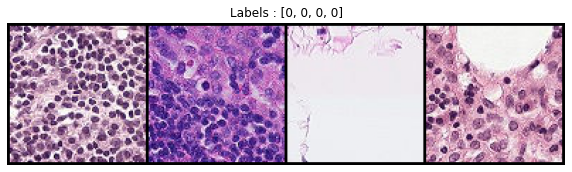

In [ ]:
nfigs = 4
idxs = np.random.randint(0,len(train_ds),nfigs)
x_ = [train_ds[i][0] for i in idxs]
y_= [train_ds[i][1] for i in idxs]
grid = torchvision.utils.make_grid(x_,nrow = nfigs)
plt.rcParams['figure.figsize'] = (10,5)
show(grid,y_)


In [ ]:
train_transforms = transforms.Compose([
                                      transforms.RandomVerticalFlip(p=0.5),
                                      transforms.RandomHorizontalFlip(p=0.5),
                                      transforms.RandomRotation(30),
                                      transforms.ToTensor()])

val_transforms = transforms.Compose([transforms.ToTensor()])

train_ds.transform = train_transforms
val_ds.transform = val_transforms


In [ ]:
train_dl = DataLoader(train_ds,batch_size = 32,shuffle=True)
val_dl = DataLoader(val_ds,batch_size = 32, shuffle = True)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from torchvision.models import resnet34
model = resnet34(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [ ]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
num_classes = 2
n_filters = model.fc.in_features
model.fc = nn.Linear(n_filters,num_classes)

In [ ]:
model.to(device)
pass

In [ ]:
def metrics_batch(output,target):
  pred = output.argmax(dim=1,keepdim=True)
  y_correct = pred.eq(target.view_as(pred)).sum().item()
  return y_correct

In [ ]:
def loss_batch(lossfn,output,target,optim = None):
  loss = lossfn(output,target)
  metric_b = metrics_batch(output,target)
  
  if optim is not None:
    optim.zero_grad()
    loss.backward()
    optim.step()
  
  return loss.item(),metric_b

In [ ]:
def loss_epoch(model,lossfn,dl,optim=None,sanity_check=False):
  run_loss = 0.0
  run_acc = 0.0
  len_data = len(dl.dataset)

  for xb,yb in dl:
    xb = xb.to(device)
    yb = yb.to(device)
    output = model(xb)
    loss_b,metric_b = loss_batch(lossfn,output,yb,optim)

    run_loss += loss_b

    if metric_b is not None:
      run_acc += metric_b
    
    if sanity_check is True:
      break
    
  loss = run_loss/float(len_data)
  acc = run_acc/float(len_data)

  return loss,acc
    



In [ ]:
def train_loop(model,params):
  epochs = params['epochs']
  lossfn = params['loss_func']
  optim = params['optimizer']
  train_dl = params['train_dl']
  val_dl = params["val_dl"]
  lr_scheduler = params['lr_scheduler']
  sanity_check = params['sanity_check']
  path = params['path']

  loss_history = {
      "train": [],
      "val": [] 
      }
  acc_history = {
      "train": [],
      "val": []
      }
  
  best_model_wts = copy.deepcopy(model.state_dict())

  best_loss = float("inf")

  for epoch in range(epochs):
    print('Epoch :',epoch) 

    model.train()
    train_loss, train_acc = loss_epoch(model,lossfn,train_dl,optim,sanity_check=sanity_check)

    loss_history["train"].append(train_loss)
    acc_history["train"].append(train_acc)

    model.eval()
    with torch.no_grad():
      val_loss,val_metric = loss_epoch(model,lossfn,val_dl,sanity_check=sanity_check)
    
    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())

      torch.save(model.state_dict,path)

    loss_history['val'].append(val_loss)
    acc_history['val'].append(val_metric)

    lr_scheduler.step()

    print(f'train loss : {train_loss:.6f}, val loss : {val_loss:.6f}, accuracy : {100*val_metric}')
    print("-"*15)
  
  
  return model, loss_history, acc_history

In [ ]:
lossfn = nn.NLLLoss(reduction='sum')
optim = Adam(model.parameters(),lr = 1e-04)
lr_scheduler = CosineAnnealingLR(optim,T_max=2,eta_min = 1e-5)

train_parameters = {
                    "epochs": 10,
                    "optimizer": optim,
                    "loss_func": lossfn,
                    "train_dl": train_dl,
                    "val_dl": val_dl,
                    "sanity_check": True,
                    "lr_scheduler": lr_scheduler,
                    "path":'/content/model/model.pt',
                    }

In [ ]:
trained_model, loss_hist, acc_hist = train_loop(model,train_parameters)

In [ ]:
lossfn = nn.CrossEntropyLoss()
optim = Adam(model.parameters(),lr = 1e-04)


train_parameters = {
                    "epochs": 10,
                    "optimizer": optim,
                    "loss_func": lossfn,
                    "train_dl": train_dl,
                    "val_dl": val_dl,
                    "sanity_check": False,
                    #"lr_scheduler": lr_scheduler,
                    "path":'/content/model/model.pt',
                    }

In [ ]:
loss_hist

{'train': [-5.606356134144857e-05,
  -5.868079648507128e-05,
  -0.00013600817432106658,
  -0.00012955358388437195,
  -0.00012581909451887238,
  -0.0001497466541693815,
  -0.0001878607721440346,
  -0.00021141649525133863,
  -0.0002033568690980162,
  -0.00028842249427000485],
 'val': [0.00020033911458065178,
  -0.00016821930725701003,
  -8.119051733581522e-05,
  -0.0003814331876487979,
  -0.000660494134827319,
  -0.0010155499977031197,
  -0.0014080979934864024,
  -0.0010526014097630063,
  -0.0012006239733388783,
  -0.002201580250890346]}

In [ ]:
model = resnet34(pretrained=True)
num_classes = 2
n_filters = model.fc.in_features
model.fc = nn.Linear(n_filters,num_classes)
model.to(device)

lossfn = nn.CrossEntropyLoss()
optim = Adam(model.parameters(),lr = 1e-04)


train_parameters = {
                    "epochs": 10,
                    "optimizer": optim,
                    "loss_func": lossfn,
                    "train_dl": train_dl,
                    "val_dl": val_dl,
                    "sanity_check": False,
                    "lr_scheduler": lr_scheduler,
                    "path":'/content/model/bestmodel.pt',
                    }

In [ ]:
trained_model_, loss_hist_, acc_hist_ = train_loop(model,train_parameters)

Epoch : 0
train loss : 0.006103, val loss : 0.004298, accuracy : 95.15055107374162
---------------
Epoch : 1
train loss : 0.003734, val loss : 0.003749, accuracy : 95.77548005908419
---------------
Epoch : 2
train loss : 0.002602, val loss : 0.003271, accuracy : 96.2163390523804
---------------
Epoch : 3
train loss : 0.001773, val loss : 0.003156, accuracy : 96.62765594818771
---------------
Epoch : 4
train loss : 0.001308, val loss : 0.003789, accuracy : 96.1913418929667
---------------
Epoch : 5
train loss : 0.001002, val loss : 0.003778, accuracy : 96.35268719463697
---------------
Epoch : 6
train loss : 0.000851, val loss : 0.004709, accuracy : 95.78002499715942
---------------
Epoch : 7
train loss : 0.000747, val loss : 0.004438, accuracy : 96.29133053062152
---------------
Epoch : 8
train loss : 0.000656, val loss : 0.004374, accuracy : 95.88683104192705
---------------
Epoch : 9
train loss : 0.000589, val loss : 0.005268, accuracy : 95.91182820134075
---------------


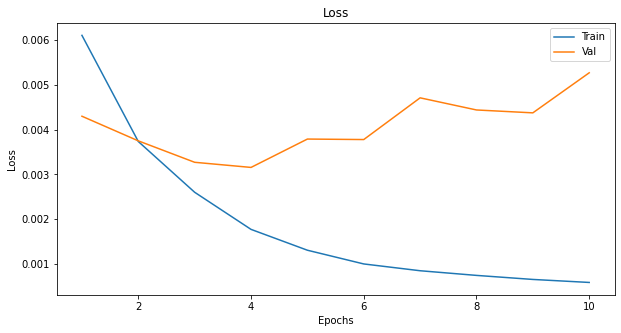

In [ ]:
plt.title("Loss")
plt.plot(range(1,train_parameters["epochs"]+1),loss_hist_["train"], label ="Train")
plt.plot(range(1,train_parameters["epochs"]+1),loss_hist_["val"], label ="Val")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

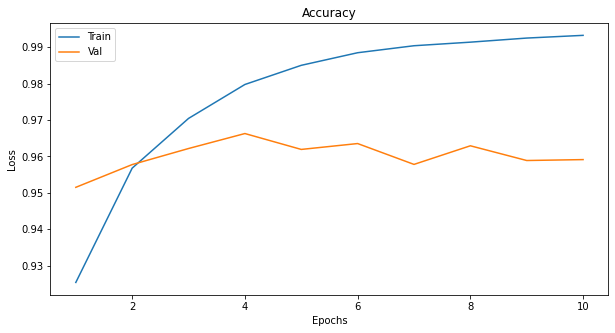

In [ ]:
plt.title("Accuracy")
plt.plot(range(1,train_parameters["epochs"]+1),acc_hist_["train"], label ="Train")
plt.plot(range(1,train_parameters["epochs"]+1),acc_hist_["val"], label ="Val")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()